In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
#load the KMNIST data
train_images = np.load("/content/kmnist-train-imgs.npz")['arr_0']
train_labels = np.load("/content/kmnist-train-labels.npz")['arr_0']
test_images = np.load("/content/kmnist-test-imgs.npz")['arr_0']
test_labels = np.load("/content/kmnist-test-labels.npz")['arr_0']

In [3]:
# preprocess the data
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [4]:
# convert the labels to one-hot
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [5]:
# define the dataset
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(len(train_images)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

In [47]:
# define the Stacked Autoencoder Network (SAE) for classification purpose
class StackedAutoencoder(tf.keras.Model):
    def __init__(self, layer_sizes, num_classes, model_input_shape):
        super(StackedAutoencoder,self).__init__()
        self.model_input_shape = model_input_shape
        self.encoder_layers  = [tf.keras.layers.Dense(size,activation='relu') for size in layer_sizes[:-1]]
        self.bottleneck_layer = tf.keras.layers.Dense(layer_sizes[-1], activation = 'relu')
        self.decoder_layers = [tf.keras.layers.Dense(size, activation='relu') for size in reversed(layer_sizes[:-1])]
        self.output_layer = tf.keras.layers.Dense(np.prod(model_input_shape), activation='sigmoid')
        self.constellation_targets = self.add_weight(shape=(num_classes, layer_sizes[-1]), initializer = 'uniform', trainable = False)

    def encode(self,x):
        for layer in self.encoder_layers:
            x = layer(x)
        return self.bottleneck_layer(x)

    def decode(self,x):
        for layer in self.decoder_layers:
            x = layer(x)
        x = self.output_layer(x)
        #print("Shape after output layer:", x.shape)
        return x

    def call(self,inputs):
        latent_code = self.encode(inputs)
        reconstruction = self.decode(latent_code)
        #print("Shape before reshape in call:", reconstruction.shape)
        reconstruction = tf.reshape(reconstruction, [-1, np.prod(self.model_input_shape)])
        return reconstruction, latent_code

# training step with the regularizer
def train_step(model, images, labels, optimizer, lambda_val):
    with tf.GradientTape() as tape:
        images_flat = tf.reshape(images, [-1,np.prod(model.model_input_shape)])
        reconstruction, latent_code = model(images_flat, training=True)
        #print("Reconstruction shape in train_step:", reconstruction.shape)
        #print("Latent code shape in train_step:", latent_code.shape)
        # MSE reconstruction loss
        loss = tf.reduce_mean(tf.losses.mean_squared_error(images_flat, reconstruction))
        #convert labels from one hot encoding to indices
        label_indices = tf.argmax(labels, axis=1)
        # regularizer based on constellation targets
        targets = tf.gather(model.constellation_targets, label_indices)
        distance = tf.norm(latent_code - targets, axis =1)
        regularizer_loss = lambda_val * tf.reduce_mean(distance)
        # total loss
        total_loss = loss + regularizer_loss

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, loss, regularizer_loss


# define hyperparameters
layer_sizes = [800, 200, 10]
num_classes = 10
lambda_val = 0.05 # regularization weight
epochs = 5
batch_size = 32

# compile the model
input_shape = train_images.shape[1:]
model = StackedAutoencoder(layer_sizes, num_classes,model_input_shape = input_shape )
optimizer = tf.keras.optimizers.Adam()


import time
# training loop
start_time = time.time()
history = { 'total_loss':[], 'mse_loss':[], 'regularizer_loss':[]}
for epoch in range(epochs):
    for step, (images, labels) in enumerate(train_dataset):
        total_loss, mse_loss, regularizer_loss = train_step(model, images, labels, optimizer, lambda_val)
        history['total_loss'].append(total_loss.numpy())
        history['mse_loss'].append(mse_loss.numpy())
        history['regularizer_loss'].append(regularizer_loss.numpy())
    print(f"Epoch {epoch+1}/{epochs}, Total_loss:{total_loss:.4f}, MSE_loss : {mse_loss:.4f}")
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f}s")


Epoch 1/5, Total_loss:0.1095, MSE_loss : 0.1056
Epoch 2/5, Total_loss:0.1109, MSE_loss : 0.1065
Epoch 3/5, Total_loss:0.1318, MSE_loss : 0.1272
Epoch 4/5, Total_loss:0.1168, MSE_loss : 0.1124
Epoch 5/5, Total_loss:0.1049, MSE_loss : 0.1007
Training completed in 1069.53s


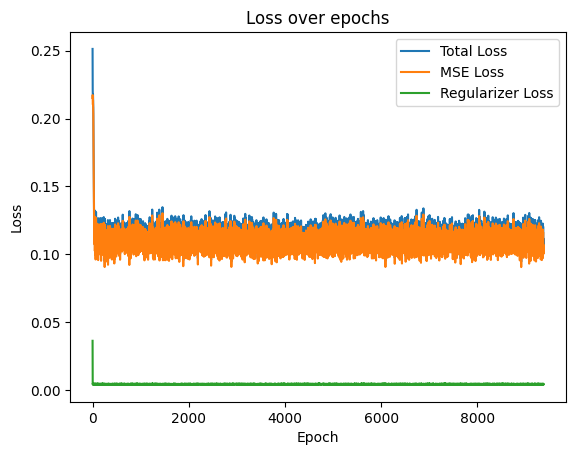

In [48]:
# visualize total_loss, mse_loss, and regularizer loss
plt.plot(history['total_loss'], label = 'Total Loss')
plt.plot(history['mse_loss'], label = 'MSE Loss')
plt.plot(history['regularizer_loss'], label = 'Regularizer Loss')
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.legend()
plt.show()


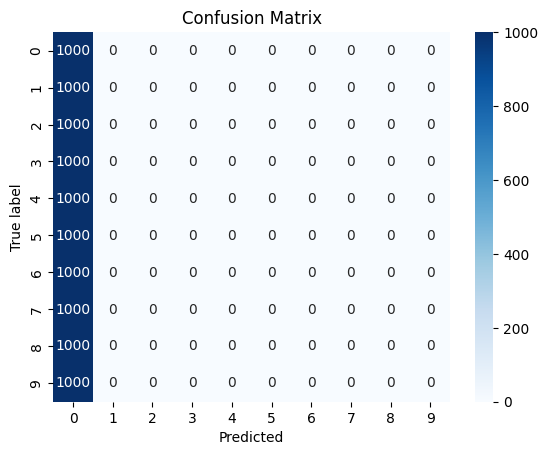

In [53]:
# confusion matrix
def make_predictions(model, dataset):
    predictions = []
    true_labels = []
    for images, _ in dataset:
        images_flat = tf.reshape(images, [-1, np.prod(model.model_input_shape)])
        reconstruction, latent_code = model(images_flat, training = False)
        predicted_labels = tf.argmax(latent_code, axis =1).numpy()
        #true_labels.extend(tf.argmax(labels, axis=1).numpy())
        predictions.extend(predicted_labels)
    return predictions

# make predictions on the test dataset
classifier_predictions = make_predictions(model, test_dataset)

test_labels_indices = test_labels

# plot confusion matrix
confusion_mtx = confusion_matrix(test_labels_indices, classifier_predictions)
sns.heatmap(confusion_mtx, annot = True, fmt ='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
